# Uklanjanje šuma sa slika koristeći Tensorflow i autoencodere


Koristit ćemo "mnist" bazu podataka koja sadrži preko 240 tisuća primjera slika (ručno pisanih znamenki) za trening i 40 tisuća za testiranje.

In [10]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255. # mijenja vrijednosti svakog pixela na vrijednost izmedju 0 i 1
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784)) # mijenjamo oblik iz dovidimenzionalne slike
x_test = np.reshape(x_test, (10000, 784))   # u vektor piksela


In [12]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9 # svakoj vrijednosti u varijabli "x_train" i "x_test" dodaje se
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9   # random vrijednost koja reprezentira šum na slici
  
x_train_noisy = np.clip(x_train_noisy, 0., 1.) # sve vrijednosti postavljamo na vrijednosti izmedju 0 i 1
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

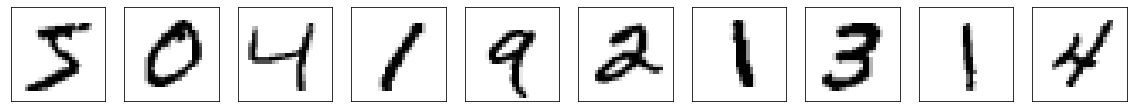

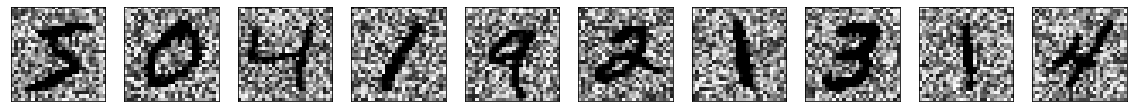

In [13]:
def plot(x, p, labels = False): #funkcija za prikaz prvih 10 slika za bilo koji set slika koji uzmemo
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1) # jedan red po 10 slika
        plt.imshow(x[i].reshape(28,28), cmap='binary') #preoblikujemo sliku u matricu 28x28 i prikazujemo ju
        plt.xticks([])                                 #binary = crno - bijelo
        plt.yticks([]) # cistimo xticks i yticks za matplotlib reshape funkciju
        if labels:
            plt.xlabel(np.argmax(p[i])) #ako se unese p i labels=True ta predvidanja ce se prikazati kao label, tj. oznaka, tj. znamenka
    plt.show()
    return

plot(x_train, None) #ispis
plot(x_train_noisy, None)

Dodajemo classifier sa dva (input i output) sloja, koristimo klasu Sequential kako bi smo mogli samo nabrojati dodatne slojeve unutar input layera. Koristimo tri sloja unutar inputa prva dva sa 256 čvora i zadnji sa 10 koji označavaju svaku zasebnu znamenku. Za aktivaciju koristimo ReLU funkciju (koristimo ju jer je brza) koja uzima tuple (0, a), a dajemo mi, i ona vraca maksimalnu vrijednost. Softmax nam služi za procjenu vjerojatnosti u koju kategoriju pripada koji input, na temelju magnituda prethodno aktiviranih neurona na prethodnim slojevima. Za optimizaciju cemo koristiti "adam" algoritam, a "sparse_categorical_crossentropy" koristimo za kategorizaciju po oznakama, tj. labelima, ona se koristi kada je samo jedna kategorija moguća za jedan primjer. Te koristimo accuracy kako bi pokazali točnost nakon korištenja classifiera.

In [14]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)


classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 1s 20us/sample - loss: 0.4291 - accuracy: 0.8824
Epoch 2/3
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1525 - accuracy: 0.9562
Epoch 3/3
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1052 - accuracy: 0.9698


In [15]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)  #provjeravamo učinak na testnom dijelu baze

10000/10000 [==============================] - 0s 43us/sample - loss: 0.1042 - accuracy: 0.9679
0.9679


In [16]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc) #vidimo da classifier nema zadovoljavajuću točnost kada koristimo podatke sa šumom

10000/10000 [==============================] - 0s 37us/sample - loss: 8.6211 - accuracy: 0.1787
0.1787


Kako bismo maknuli šum sa naših podataka, napravit ćemo autoencoder(vrsta jednostavne neuronske mreže) koja će primati podatke sa šumom kao input i originalne podatke kao label. Prvi sloj će nam imati puno manje čvorova nego što će postojati u inputu, te će nam sam proces treniranja prisiliti mrežu da nauči funkciju "principle component analysis" koja pojednostavljeno, gleda skupove točaka i pretvara ih u vektore, smanjuje dimenzionalnost i tjera naš model da nauči važnije karakteristike iz baze podataka. Koristimo sigmoid funkciju za normalizirane linearne vrijednosti, za koje ćemo dobivati 1 za visoke i 0 za niske vrijednosti. Loss argument nam ponovno radi sličnu stvar kao i gore, ali koristimo binary verziju jer ćemo dobivati samo rezultate 1 i 0.

In [17]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [18]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, #provodimo ucenje 100 puta
    batch_size=512, #uzimamo 512 primjera odjednom
    validation_split=0.2, #odvajamo 20% svakog batcha za provjeru
    verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5), #ako nam se loss ne smanji više od 5 puta uzastopno prekidamo treniranje
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print('Training is complete!')

0.256 _ 0.222 _ 0.202 _ 0.187 _ 0.173 _ 0.164 _ 0.156 _ 0.150 _ 0.145 _ 0.140 _ 0.136 _ 0.133 _ 0.130 _ 0.128 _ 0.125 _ 0.124 _ 0.122 _ 0.120 _ 0.119 _ 0.118 _ 0.117 _ 0.116 _ 0.116 _ 0.115 _ 0.114 _ 0.114 _ 0.114 _ 0.113 _ 0.113 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.112 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ 0.110 _ Training is complete!


Da dobijemo predviđanja za naše podatke sa šumom sve što sada trebamo napraviti je proslijediti te podatke kroz autoencoder.

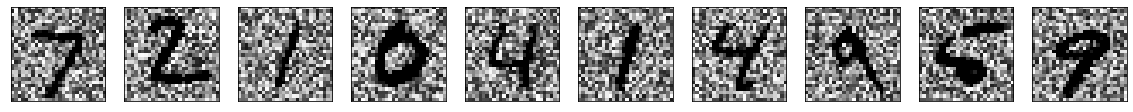

In [19]:
predictions = autoencoder.predict(x_test_noisy)
plot(x_test_noisy, None)

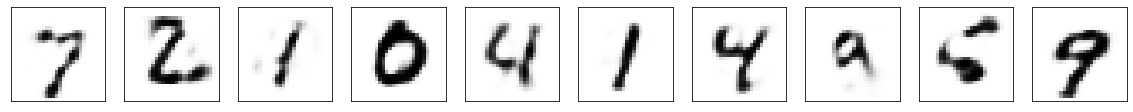

In [20]:
plot(predictions, None)

Sada želimo vidjeti kako bi naša predviđanja iz autoencodera radila sa classifierom, te koliki će ovaj puta biti accuracy.

In [21]:
loss, acc = classifier.evaluate(predictions, y_test)
print(acc)

10000/10000 [==============================] - 0s 42us/sample - loss: 0.1803 - accuracy: 0.9422
0.9422


Želimo napraviti kompozitni model, kojem možemo dati sliku sa ili bez šuma, koju će on prvo pretvoriti u sliku bez šuma, te će ju kao takvu provući kroz classifier da dobije predviđanje za klasu/label/znamenku.

In [22]:
input_image = Input(shape = (784,))
x = autoencoder(input_image)
y = classifier(x)

denoise_and_classify = Model(input_image, y)


In [23]:
predictions = denoise_and_classify.predict(x_test_noisy)

Kada smo dobili predviđanja, želimo provjeriti je li classifier odobro odredio klase/labele/zamenke, te ćemo ispisati podatke sa šumom i labele dodijeljene tim primjerima kroz classifier.

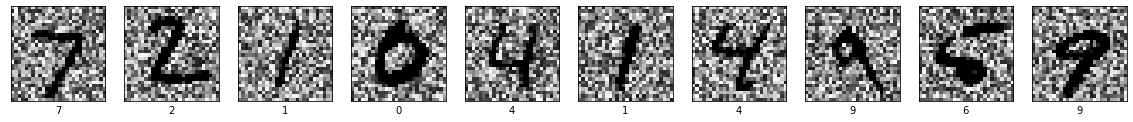

In [24]:
plot(x_test_noisy, predictions, True)

I na kraju za provjeru možemo proći kroz iste primjere bez šuma da vidimo jesmo li dobili originalne znamenke. (to_categorical nam pretvara y__test u onehot format)

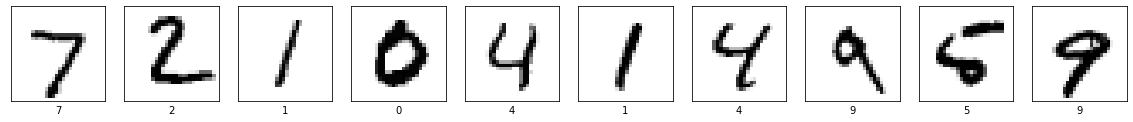

In [25]:
plot(x_test, to_categorical(y_test), True)